# Data Transformation and Preparation

In [54]:
# imports
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.metrics import root_mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# read the data
spotify = pd.read_csv('data/Hot 100 Audio Features.csv')
billboard = pd.read_csv('data/Hot Stuff.csv')

# join on song id
spotify = spotify.drop_duplicates(subset=['SongID']) # drop duplicates in spotify
df = pd.merge(spotify, billboard, on=['SongID'], how='right', validate='one_to_many')
df.drop(columns=['index_y', 'index_x', 'Performer_y', 'Song_y'], inplace = True) # get rid of index and duplicate columns

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327895 entries, 0 to 327894
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   SongID                     327895 non-null  object 
 1   Performer_x                327817 non-null  object 
 2   Song_x                     327817 non-null  object 
 3   spotify_genre              313371 non-null  object 
 4   spotify_track_id           284728 non-null  object 
 5   spotify_track_preview_url  168700 non-null  object 
 6   spotify_track_duration_ms  284728 non-null  float64
 7   spotify_track_explicit     284728 non-null  object 
 8   spotify_track_album        284666 non-null  object 
 9   danceability               284170 non-null  float64
 10  energy                     284170 non-null  float64
 11  key                        284170 non-null  float64
 12  loudness                   284170 non-null  float64
 13  mode                       28

In [3]:
# get numeric columns
num_cols = df.select_dtypes(include='number').columns.to_list()

# transform the data so that each row corresponds to a genre-year combination
# aggregate the numeric columns over that combination
df['Year'] = df['WeekID'].apply(lambda x: x.split('/')[2]) # create year column from weekid
df = df.dropna(subset=['spotify_genre']) # drop rows with no genre
df['spotify_genre'] = df['spotify_genre'].apply(ast.literal_eval) # make genre field a list not string
df = df.explode('spotify_genre') # genre is a list of genres for each song, want one genre for each song
genre_df = df.groupby(['spotify_genre', 'Year']).agg({col: 'mean' for col in num_cols}).reset_index()
song_counts = df.groupby(['spotify_genre', 'Year']).size().reset_index(name='song_count') # get song counts
genre_df = pd.merge(genre_df, song_counts, on=['spotify_genre', 'Year'], how='left') # merge song counts with genre_df

# add lag features for each numeric column
for col in num_cols:
    genre_df[f'{col}_lag1'] = genre_df.groupby('spotify_genre')[col].shift(1) # 1 year lag feature for each numeric column
    genre_df[f'{col}_lag2'] = genre_df.groupby('spotify_genre')[col].shift(2) # 2 year lag feature for each numeric column
    
# add lag features for song count
genre_df['song_count_lag1'] = genre_df.groupby('spotify_genre')['song_count'].shift(1) # 1 year lag feature for song count
genre_df['song_count_lag2'] = genre_df.groupby('spotify_genre')['song_count'].shift(2) # 2 year lag feature for song count
    
# now add my target variable, song count 2 years later
genre_df['song_count_2yr'] = genre_df.groupby('spotify_genre')['song_count'].shift(-2) # song count 2 years later

print(genre_df.head())
print(genre_df.info())

# export the data to csv
genre_df.to_csv('data/genre_df.csv', index=False)

            spotify_genre  Year  spotify_track_duration_ms  danceability  \
0  21st century classical  1969                        NaN           NaN   
1              a cappella  1960                        NaN           NaN   
2              a cappella  1962              176153.777778      0.447222   
3              a cappella  1963              174740.423729      0.516186   
4              a cappella  1964              181078.444444      0.607444   

     energy       key   loudness      mode  speechiness  acousticness  ...  \
0       NaN       NaN        NaN       NaN          NaN           NaN  ...   
1       NaN       NaN        NaN       NaN          NaN           NaN  ...   
2  0.175333  4.333333 -18.251556  0.111111     0.049922      0.848778  ...   
3  0.218542  6.067797 -18.188373  1.000000     0.038598      0.717441  ...   
4  0.252333  3.333333 -11.744889  1.000000     0.034522      0.776333  ...   

   Instance_lag2  Previous Week Position_lag1  Previous Week Position_lag2

# Exploratory Data Analysis

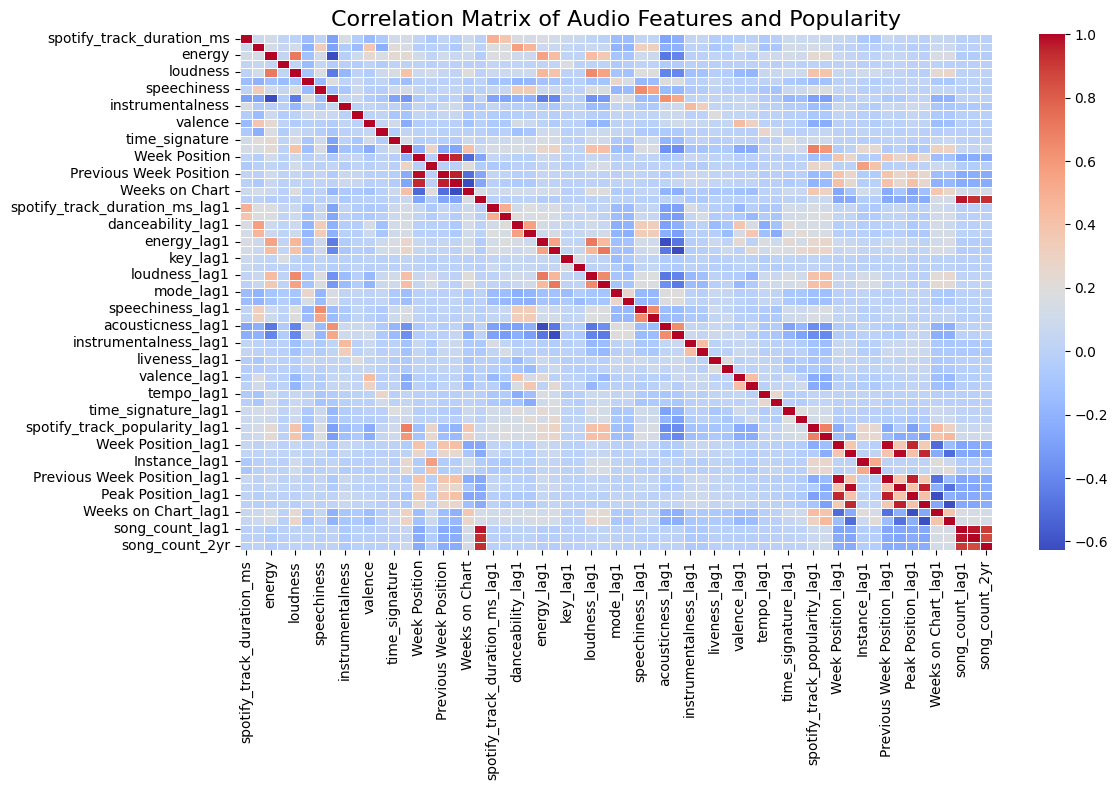

In [4]:
# plot correlation matrix heatmap
corr = genre_df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix of Audio Features and Popularity", fontsize=16)
plt.tight_layout()
plt.show()

<Axes: >

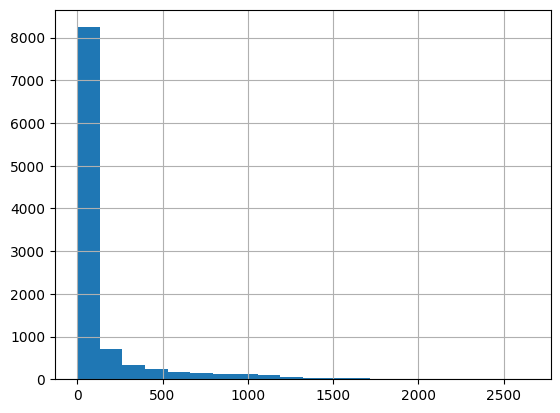

In [5]:
# explore target variable distribution
genre_df['song_count_2yr'].hist(bins=20)

After looking at the distribution of my target variable, it's clearly very skewed. Most models trained with this raw target variable will simply learn to predict a lower song count. To try and fix this, I'll perform a log transformation which will make the distribution more normal. The model will learn with the log-transformed values instead and when I get the prediction I can inverse the transformation to get raw song counts again.

<Axes: >

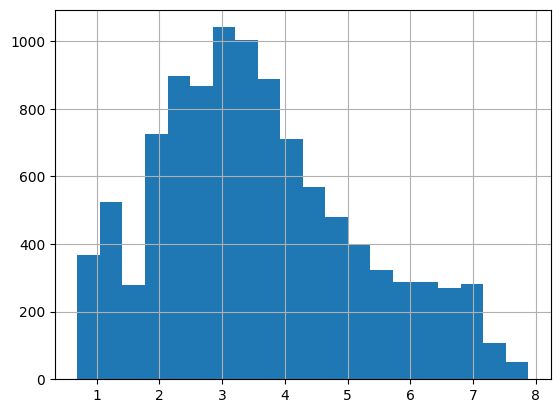

In [6]:
# log transform the target variable to make distribution more normal
genre_df['song_count_2yr'] = np.log1p(genre_df['song_count_2yr'])
genre_df['song_count_2yr'].hist(bins=20)

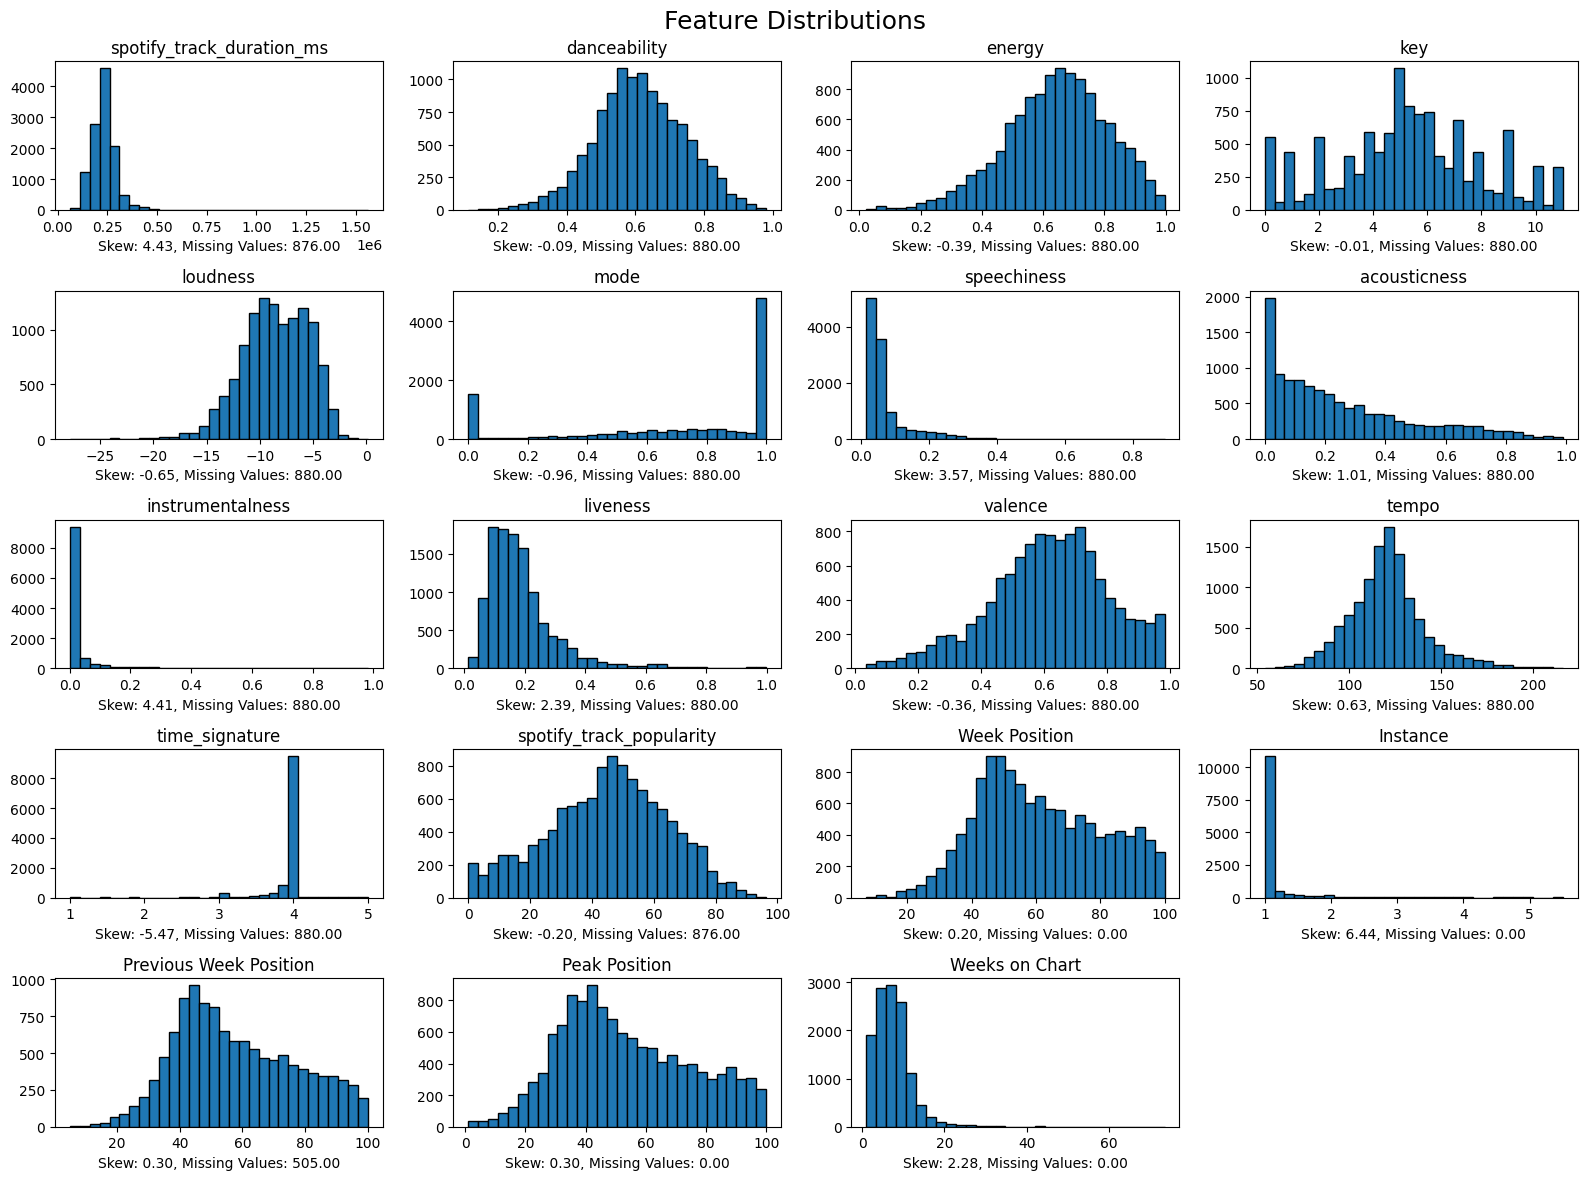

In [7]:
# let's look at numerical feature distributions (exclude lag features since the same)
ax = genre_df[num_cols].hist(
    bins=30,
    figsize=(16, 12),
    edgecolor='black',
    grid=False
)

# add skewness to each plot
axes = ax.flatten()
for ax, col in zip(axes, num_cols):
    skew_val = genre_df[col].skew()
    total_nas = genre_df[col].isna().sum()
    ax.set_xlabel(f'Skew: {skew_val:.2f}, Missing Values: {total_nas:.2f}', fontsize=10)

plt.suptitle('Feature Distributions', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

We can use the knowledge of the distributions (and level of skewness) to handle missing data now. If data is skewed, we can impute with median value since this will better reflect the typical distribution of that feature. This is becuase median is robust to outliers while mean can be greatly affected by just a few very different data points. If the distribution is already relatively normal, using mean should be fine.

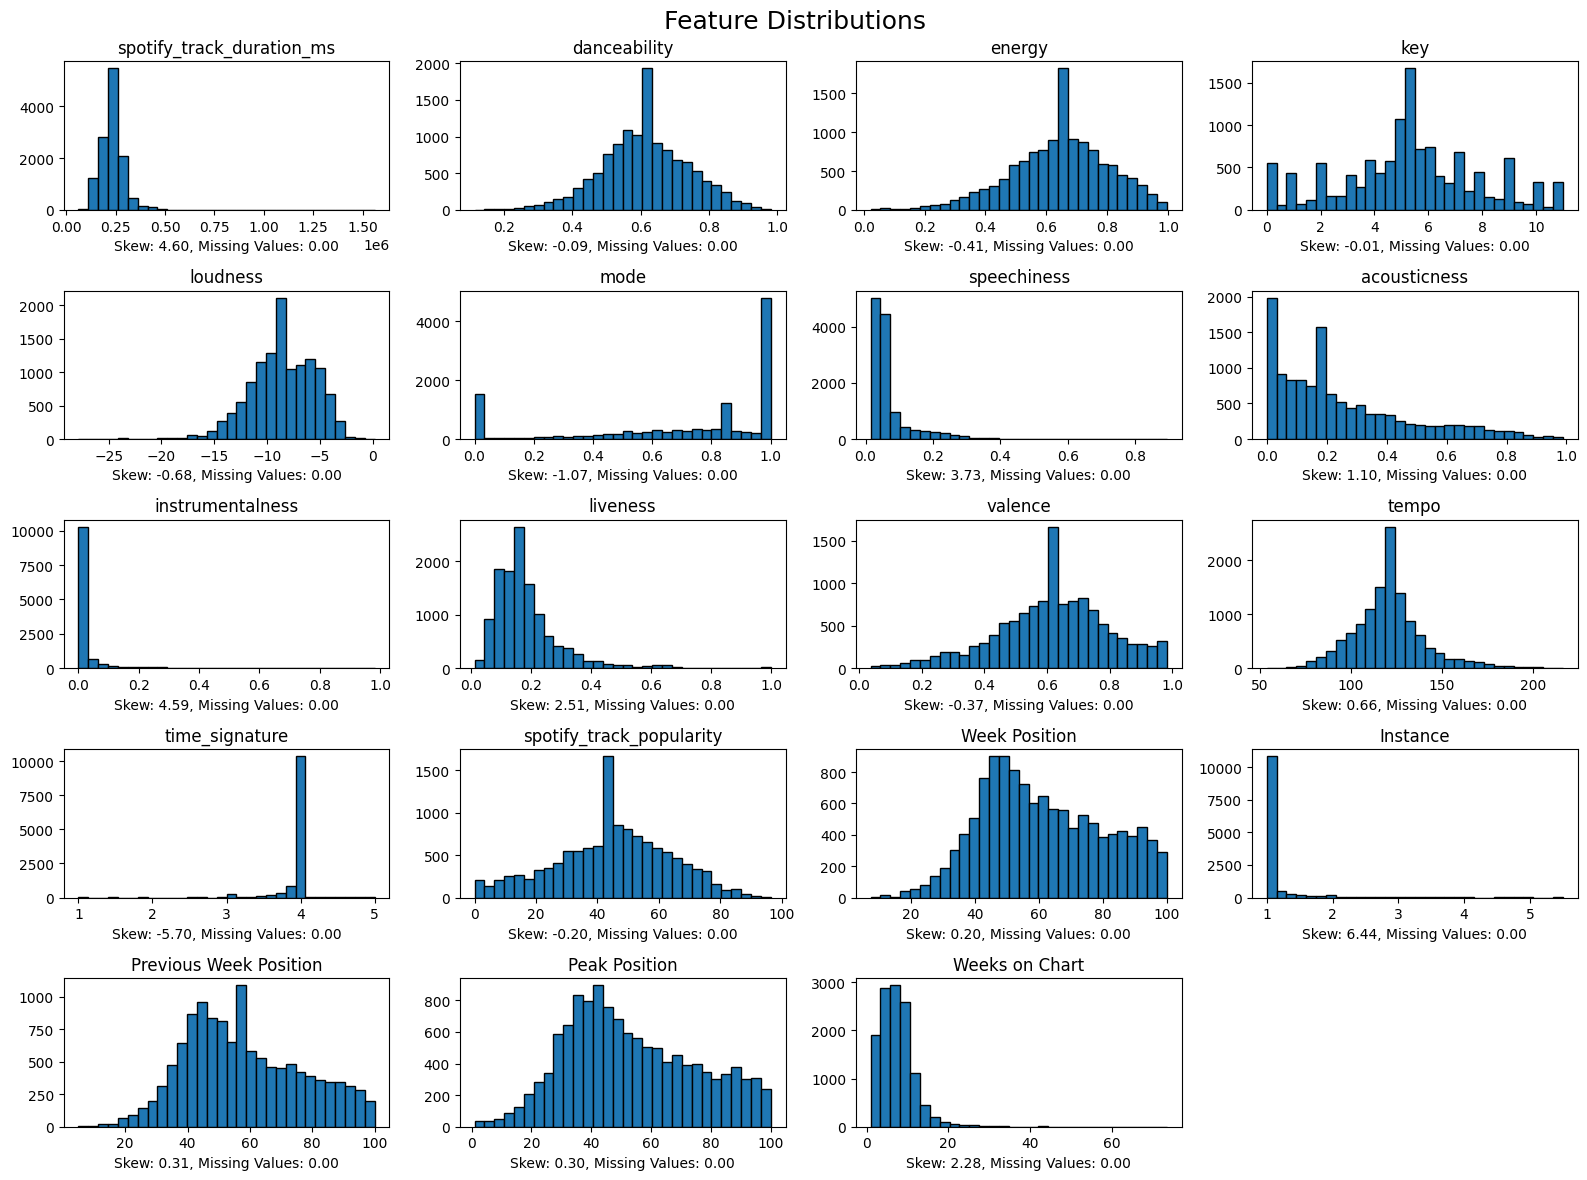

In [8]:
# handle missing values
# lag features with na will be dropped before training
for col in num_cols:
    # if abs(skew) is > 0.5, then I'll impute with median, else mean is fine (normal distribution)
    skew = genre_df[col].skew()
    if abs(skew) > 0.5:
        genre_df[col] = genre_df[col].fillna(genre_df[col].median())
    else:
        genre_df[col] = genre_df[col].fillna(genre_df[col].mean())
        
# plot distributions again to see changes
ax = genre_df[num_cols].hist(
    bins=30,
    figsize=(16, 12),
    edgecolor='black',
    grid=False
)

# add skewness to each plot
axes = ax.flatten()
for ax, col in zip(axes, num_cols):
    skew_val = genre_df[col].skew()
    total_nas = genre_df[col].isna().sum()
    ax.set_xlabel(f'Skew: {skew_val:.2f}, Missing Values: {total_nas:.2f}', fontsize=10)

plt.suptitle('Feature Distributions', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

Now, before PCA and model training, I'll do final data preparation. First, I'll split off the records with missing target variable and save it for out of sample forecasting (for future years). Next, I'll remove all the samples with missing lag features as they will not be used for training. Finally, I'll be left with no missing data and will then create a separate normalized dataframe that will be used for PCA, linear regression, and neural network. I'll keep the raw data for my tree based model.

In [9]:
# save data with missing target variable
oos_df = genre_df[genre_df['song_count_2yr'].isna()]

# remove all samples with missing lag features (only columns with remainning missing data)
print(genre_df.info())
genre_df = genre_df.dropna()
print(genre_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12383 entries, 0 to 12382
Data columns (total 63 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   spotify_genre                   12383 non-null  object 
 1   Year                            12383 non-null  object 
 2   spotify_track_duration_ms       12383 non-null  float64
 3   danceability                    12383 non-null  float64
 4   energy                          12383 non-null  float64
 5   key                             12383 non-null  float64
 6   loudness                        12383 non-null  float64
 7   mode                            12383 non-null  float64
 8   speechiness                     12383 non-null  float64
 9   acousticness                    12383 non-null  float64
 10  instrumentalness                12383 non-null  float64
 11  liveness                        12383 non-null  float64
 12  valence                         

['spotify_track_duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'spotify_track_popularity', 'Week Position', 'Instance', 'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'song_count', 'spotify_track_duration_ms_lag1', 'spotify_track_duration_ms_lag2', 'danceability_lag1', 'danceability_lag2', 'energy_lag1', 'energy_lag2', 'key_lag1', 'key_lag2', 'loudness_lag1', 'loudness_lag2', 'mode_lag1', 'mode_lag2', 'speechiness_lag1', 'speechiness_lag2', 'acousticness_lag1', 'acousticness_lag2', 'instrumentalness_lag1', 'instrumentalness_lag2', 'liveness_lag1', 'liveness_lag2', 'valence_lag1', 'valence_lag2', 'tempo_lag1', 'tempo_lag2', 'time_signature_lag1', 'time_signature_lag2', 'spotify_track_popularity_lag1', 'spotify_track_popularity_lag2', 'Week Position_lag1', 'Week Position_lag2', 'Instance_lag1', 'Instance_lag2', 'Previous Week Position_lag1', 'Previous Wee

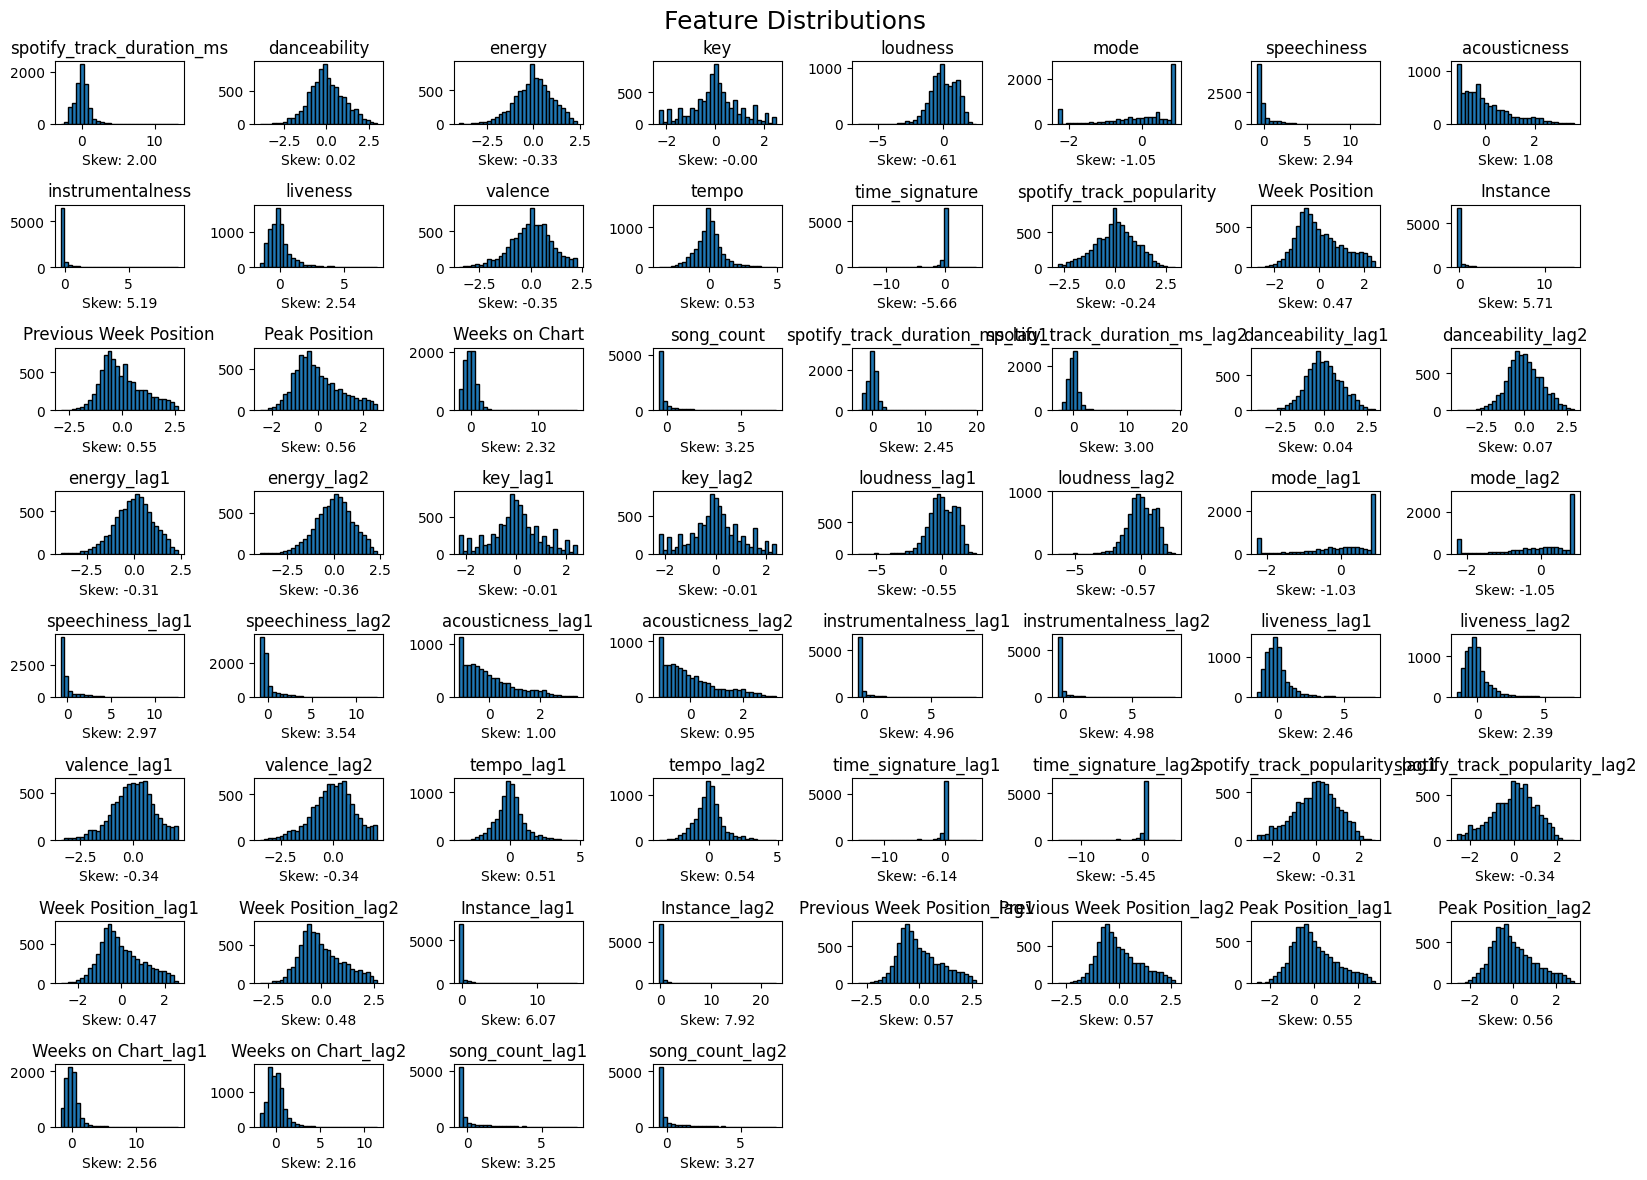

In [10]:
# normalize the data
scaler = StandardScaler()
genre_df_normalized = genre_df.copy(deep=True)
num_cols = [col for col in genre_df.select_dtypes(include='number').columns
            if col not in ['song_count_2yr']] # exclude target variable from normalization
print(num_cols)
genre_df_normalized[num_cols] = scaler.fit_transform(genre_df_normalized[num_cols])

# plot distributions again to see changes
ax = genre_df_normalized[num_cols].hist(
    bins=30,
    figsize=(16, 12),
    edgecolor='black',
    grid=False
)

# add skewness to each plot
axes = ax.flatten()
for ax, col in zip(axes, num_cols):
    skew_val = genre_df_normalized[col].skew()
    ax.set_xlabel(f'Skew: {skew_val:.2f}', fontsize=10)

plt.suptitle('Feature Distributions', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [11]:
# differences between normalized and non-normalized data
print(genre_df_normalized.head(5))
print(genre_df.head(5))

  spotify_genre  Year  spotify_track_duration_ms  danceability    energy  \
4    a cappella  1964                  -1.031384     -0.052835 -2.623271   
5    a cappella  1965                  -1.349666     -0.331727 -1.939548   
6    a cappella  1966                  -0.977282      0.223734 -1.431629   
7    a cappella  1967                  -1.595956      0.139281 -0.933760   
8    a cappella  1968                  -1.624499     -0.965606 -1.011442   

        key  loudness      mode  speechiness  acousticness  ...  \
4 -0.850510 -1.079112  0.920685    -0.587843      2.606572  ...   
5  0.313808 -1.209127  0.920685    -0.595739      2.294773  ...   
6 -1.432668 -2.654077  0.920685    -0.684778      2.624407  ...   
7 -0.662164 -0.561407  0.920685    -0.412883      0.001248  ...   
8  0.750427 -1.214797  0.920685    -0.317120      0.756608  ...   

   Instance_lag2  Previous Week Position_lag1  Previous Week Position_lag2  \
4      -0.296134                    -1.154315                 

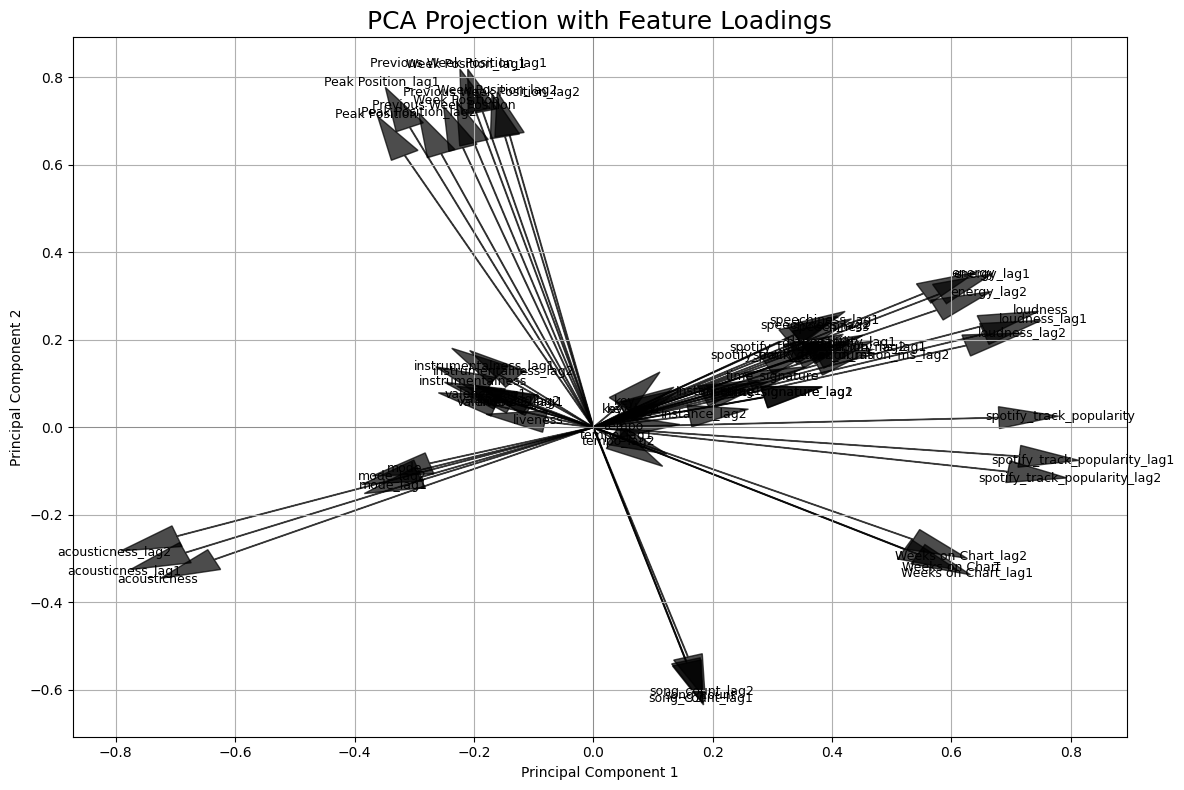

In [12]:
# PCA to visualize data separation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(genre_df_normalized[num_cols])

# Set up the plot
plt.figure(figsize=(12, 8))

# Plot the PCA loadings (arrows)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

for i, feature in enumerate(num_cols):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1],
              color='black', alpha=0.7, head_width=0.05, head_length=0.1)
    plt.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, feature, 
             color='black', ha='center', va='center', fontsize=9)

# Titles and labels
plt.title('PCA Projection with Feature Loadings', fontsize=18)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.grid(True)
plt.tight_layout()
plt.show()

Here we can see that lag features obvious add a good amount of multicollinearity which is important to remove for linear models. So, I'll be using Lasso Regression (learned about it in my Intro to Statistical Learning class) to regularize and perform feature selection for me.

# Model Training

In [13]:
# Define features to use
feature_cols = [col for col in genre_df_normalized.columns if col not in ['spotify_genre', 'Year', 'song_count_2yr']]

# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    genre_df_normalized[feature_cols],
    genre_df_normalized['song_count_2yr'],
    test_size=0.15,
    random_state=1
)

In [14]:
# train Lasso model
lasso = LassoCV(cv=5, random_state=1)
lasso.fit(X_train, y_train)

# view coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso.coef_
})

print(coef_df.sort_values(by='Coefficient', ascending=False))

                           Feature  Coefficient
19                      song_count     1.060621
54              Peak Position_lag1     0.221883
49              Week Position_lag2     0.149232
17                   Peak Position     0.113047
16          Previous Week Position     0.081310
46   spotify_track_popularity_lag1     0.074301
21  spotify_track_duration_ms_lag2     0.040530
6                      speechiness     0.031049
13        spotify_track_popularity     0.029961
1                     danceability     0.027497
47   spotify_track_popularity_lag2     0.023482
11                           tempo     0.022584
23               danceability_lag2     0.022111
40                    valence_lag1     0.014810
30                       mode_lag1     0.012549
0        spotify_track_duration_ms     0.010581
22               danceability_lag1     0.010026
18                  Weeks on Chart     0.008693
10                         valence     0.007538
20  spotify_track_duration_ms_lag1     0

In [15]:
# Predict on validation set
y_train_pred_log = lasso.predict(X_train)
y_test_pred_log = lasso.predict(X_test)

# get y values in original non-log scale for evaluation
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)
y_train_original = np.expm1(y_train)
y_test_original = np.expm1(y_test)

# Evaluate
rmse_log_train = root_mean_squared_error(y_train, y_train_pred_log)
# rmse_train =  np.sqrt(mean_squared_error(y_train_original, y_train_pred))# convert back to original scale for true rmse
r2_log_train = r2_score(y_train, y_train_pred_log)

rmse_log_test = root_mean_squared_error(y_test, y_test_pred_log)
# rmse_test = np.sqrt(mean_squared_error(y_test_original, y_test_pred)) # convert back to original scale for true rmse
r2_log_test = r2_score(y_test, y_test_pred_log)

print(f"Best alpha: {lasso.alpha_:.5f}")
print()
# print(f"Train RMSE: {rmse_train:.3f}")
print(f"Train RMSE (log scale): {rmse_log_train:.3f}")
print(f"Train R² (log space): {r2_log_train:.3f}")
print()
# print(f"Test RMSE: {rmse_test:.3f}")
print(f"Test RMSE (log scale): {rmse_log_test:.3f}")
print(f"Test R² (log space): {r2_log_test:.3f}")

Best alpha: 0.00178

Train RMSE (log scale): 1.106
Train R² (log space): 0.546

Test RMSE (log scale): 1.145
Test R² (log space): 0.519


The Lasso model performed pretty well. 5 folds were chosen for CV (to tune for alpha), but more experimentation will be done if Lasso proves to do better off initial training than the proceeding models. Viewing the coefficients helped to see which features got selected and/or were emphasized more. There doesn't appear to be any overfitting occuring which is good, but there is some underfit and we could probably get some better results with a more complex (maybe non-linear) model. So, next I am going to try XGBoost.

In [16]:
# Define features to use
feature_cols = [col for col in genre_df.columns if col not in ['spotify_genre', 'Year', 'song_count_2yr']]

# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    genre_df[feature_cols],
    genre_df['song_count_2yr'],
    test_size=0.15,
    random_state=1
)

In [17]:
# cross validation with XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100, 
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
)

# 5-fold cross-validation
cv_rmse_log = -cross_val_score(xgb_model, X_train, y_train, 
                           scoring='neg_root_mean_squared_error', cv=5)
cv_r2 = cross_val_score(xgb_model, X_train, y_train, 
                           scoring='r2', cv=5)

print(f"Cross-validated RMSE: {np.mean(cv_rmse_log):.3f}")
print(f"Cross-validated R²: {np.mean(cv_r2):.3f}")

Cross-validated RMSE: 0.881
Cross-validated R²: 0.711


In [18]:
# fit on full training set
xgb_model.fit(X_train, y_train)

# make predictions
y_train_pred_log = xgb_model.predict(X_train)
y_test_pred_log = xgb_model.predict(X_test)

# evaluate
rmse_log_train = root_mean_squared_error(y_train, y_train_pred_log)
rmse_log_test = root_mean_squared_error(y_test, y_test_pred_log)
r2_log_train = r2_score(y_train, y_train_pred_log)
r2_log_test = r2_score(y_test, y_test_pred_log)

print(f"Train RMSE (log scale): {rmse_log_train:.3f}")
print(f"Train R² (log space): {r2_log_train:.3f}")
print()
print(f"Test RMSE (log scale): {rmse_log_test:.3f}")
print(f"Test R² (log space): {r2_log_test:.3f}")

Train RMSE (log scale): 0.641
Train R² (log space): 0.847

Test RMSE (log scale): 0.904
Test R² (log space): 0.700


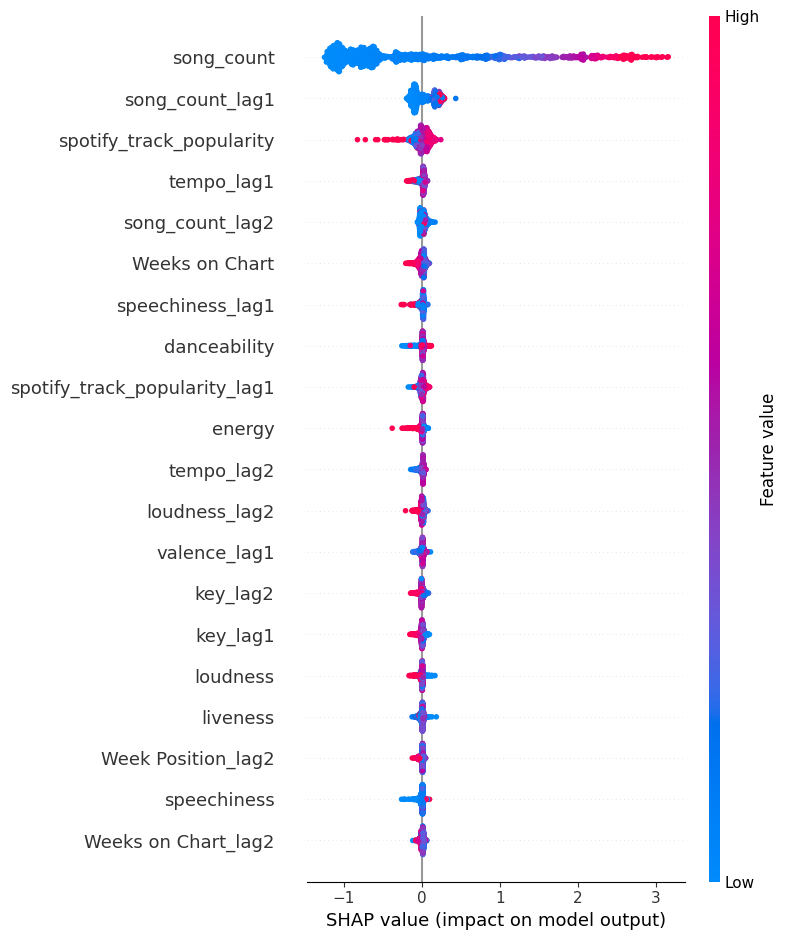

In [19]:
# SHAP values for feature importance, see how the model works
explainer = shap.Explainer(xgb_model)

# Compute SHAP values for test data
shap_values = explainer(X_test)

# Global feature importance (summary plot)
shap.summary_plot(shap_values, X_test)

XGBoost performed really well and predictably did a better job than lasso regression as it's able to capture non-linear relationships. XGBoost was able to explain 70% of variance in test data compared to just 50% for lasso, so this model made considerable strides. I plotted shap values above to see which predictors are influencing the model the most and the results I got mostly aligned with expectations. Genre song count (for current year) had the greatest predictive power with high values driving predictions upward indicating current popularity is a great indicator of future probability. Now, I'll train and evaluate one more model, a neural network.

In [20]:
# Define features to use
feature_cols = [col for col in genre_df_normalized.columns if col not in ['spotify_genre', 'Year', 'song_count_2yr']]

# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    genre_df_normalized[feature_cols],
    genre_df_normalized['song_count_2yr'],
    test_size=0.15,
    random_state=1
)

In [21]:
# Convert to torch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create Datasets and Dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# fix random seed for reproducibility
torch.manual_seed(1)

In [22]:
class FFNN(nn.Module):
    def __init__(self, input_dim):
        super(FFNN, self).__init__()
        
        # define architecture of the model
        self.fc1 = nn.Linear(input_dim, 64) # input layer -> hidden layer 1
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 32) # hidden layer 1 -> hidden layer 2
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 1)  # hidden layer 2 -> output layer

    def forward(self, x):
        # define forward pass
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

input_dim = X_train.shape[1]
model = FFNN(input_dim)

In [23]:
# train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 100

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader):.4f}, RMSE: {np.sqrt(running_loss/len(train_loader)):.4f}")

Epoch 10/100, Loss: 1.4424, RMSE: 1.2010
Epoch 20/100, Loss: 1.2082, RMSE: 1.0992
Epoch 30/100, Loss: 1.0408, RMSE: 1.0202
Epoch 40/100, Loss: 0.9435, RMSE: 0.9714
Epoch 50/100, Loss: 0.8787, RMSE: 0.9374
Epoch 60/100, Loss: 0.8322, RMSE: 0.9123
Epoch 70/100, Loss: 0.8087, RMSE: 0.8993
Epoch 80/100, Loss: 0.7869, RMSE: 0.8871
Epoch 90/100, Loss: 0.7613, RMSE: 0.8725
Epoch 100/100, Loss: 0.7444, RMSE: 0.8628


In [24]:
# evaluate on test set
model.eval()
with torch.no_grad():
    y_test_pred_log = model(X_test_tensor).squeeze()

# Compute RMSE in log space
test_rmse_log = torch.sqrt(torch.mean((y_test_pred_log - y_test_tensor.squeeze())**2)).item()

# compute R²
r2_log_test = r2_score(y_test_tensor.numpy(), y_test_pred_log.numpy())

print(f"Test RMSE (log scale): {test_rmse_log:.3f}")
print(f"Test R² (log space): {r2_log_test:.3f}")


Test RMSE (log scale): 0.963
Test R² (log space): 0.660


The architecture for my NN was originally input -> 128 node hidden -> 64 node hidden -> output, but it was struglling with overfitting so I simplified it (64 and 32 nodes for each hidden layer) and added some dropout layers after each hidden layer. Despite this light tuning, the model was still performing a bit worse than XGBoost so I've decided to choose XGBoost as my model to perform extensive fine tuning with.

In [25]:
# Define features to use
feature_cols = [col for col in genre_df.columns if col not in ['spotify_genre', 'Year', 'song_count_2yr']]

# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    genre_df[feature_cols],
    genre_df['song_count_2yr'],
    test_size=0.15,
    random_state=1
)

In [26]:
# set up parameter grid
param_dist = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 5, 10],
    'min_child_weight': [1, 3, 5]
}

# Model
xgb_model = XGBRegressor(random_state=1)

# Random Search
random_search = RandomizedSearchCV(
    estimator = xgb_model,
    param_distributions = param_dist,
    n_iter = 50,  # Number of random combinations to try
    scoring='neg_root_mean_squared_error',
    cv = 5, # 5 fold for each combination
    verbose = 2,
    random_state = 1,
    n_jobs = -1  # Use all CPU cores
)

# Run search
random_search.fit(X_train, y_train)

# Best params
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validated score: ", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 1000, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best cross-validated score:  -0.8609544109921643


Here I used random grid search to find the best hyperparameters for XG Boost. I first set up my parameter grid using my first XGBoost model as a reference since it performed relatively well. Then, I initialized the search which fit 5 folds for 50 random combinations of hyperparameters. This gave me the best parameters given above.

In [27]:
# get best parameters
best_params = random_search.best_params_

# fit final model with best parameters
final_xgb_model = XGBRegressor(
    **best_params,
    random_state = 1
)

final_xgb_model.fit(X_train, y_train)

# make predictions
y_train_pred_log = final_xgb_model.predict(X_train)
y_test_pred_log = final_xgb_model.predict(X_test)

# get y values in original non-log scale for evaluation
y_train_original = np.expm1(y_train)
y_test_original = np.expm1(y_test)
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)

# evaluate
rmse_log_train = root_mean_squared_error(y_train, y_train_pred_log)
rmse_log_test = root_mean_squared_error(y_test, y_test_pred_log)
rmse_train = root_mean_squared_error(y_train_original, y_train_pred)
rmse_test = root_mean_squared_error(y_test_original, y_test_pred)
r2_log_train = r2_score(y_train, y_train_pred_log)
r2_log_test = r2_score(y_test, y_test_pred_log)

print(f"Train RMSE (log scale): {rmse_log_train:.3f}")
print(f"Train RMSE: {rmse_train:.3f}")
print(f"Train R² (log space): {r2_log_train:.3f}")
print()
print(f"Test RMSE (log scale): {rmse_log_test:.3f}")
print(f"Test RMSE: {rmse_test:.3f}")
print(f"Test R² (log space): {r2_log_test:.3f}")

Train RMSE (log scale): 0.306
Train RMSE: 59.198
Train R² (log space): 0.965

Test RMSE (log scale): 0.887
Test RMSE: 108.994
Test R² (log space): 0.712


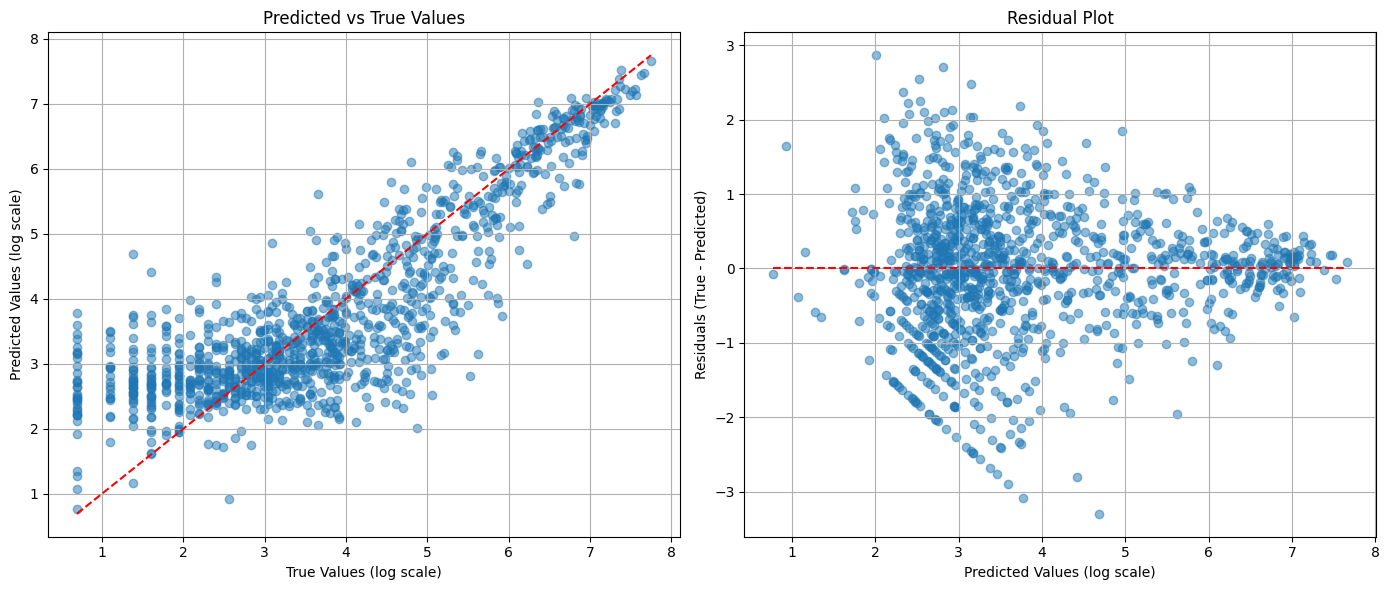

In [28]:
# Residual and predicted vs true plots
residuals = y_test - y_test_pred_log

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot 1: Predicted vs True ---
axes[0].scatter(y_test, y_test_pred_log, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal diagonal
axes[0].set_xlabel('True Values (log scale)')
axes[0].set_ylabel('Predicted Values (log scale)')
axes[0].set_title('Predicted vs True Values')
axes[0].grid(True)

# --- Plot 2: Residuals ---
axes[1].scatter(y_test_pred_log, residuals, alpha=0.5)
axes[1].hlines(0, y_test_pred_log.min(), y_test_pred_log.max(), colors='r', linestyles='dashed')
axes[1].set_xlabel('Predicted Values (log scale)')
axes[1].set_ylabel('Residuals (True - Predicted)')
axes[1].set_title('Residual Plot')
axes[1].grid(True)

plt.tight_layout()
plt.show()

Now that I've chosen and tuned a final model, I decided to go deeper into the evaluation aspect. To start with, I converted the RMSE back to the original scale of my target variable (it had been log-transformed). As you can see, the model performed very well on the test data, only missing by an average of 109 songs and explaining 71% of variance. I also took a visual look at my model's results, plotting a residual plot and predicted vs true values. These plots tell a similar story to the metrics, confirming that my model is performing adequately with most points clustered around the 'desired behavior line'. The plots do add a little bit of context as to what specifically the model is struggling and doing well with, showing that it seems to accurately predict the genres that have higher future song counts, but stuggle with the lower future song count genres. This is something I'd look to investigate more in any next steps I'd have for this project.

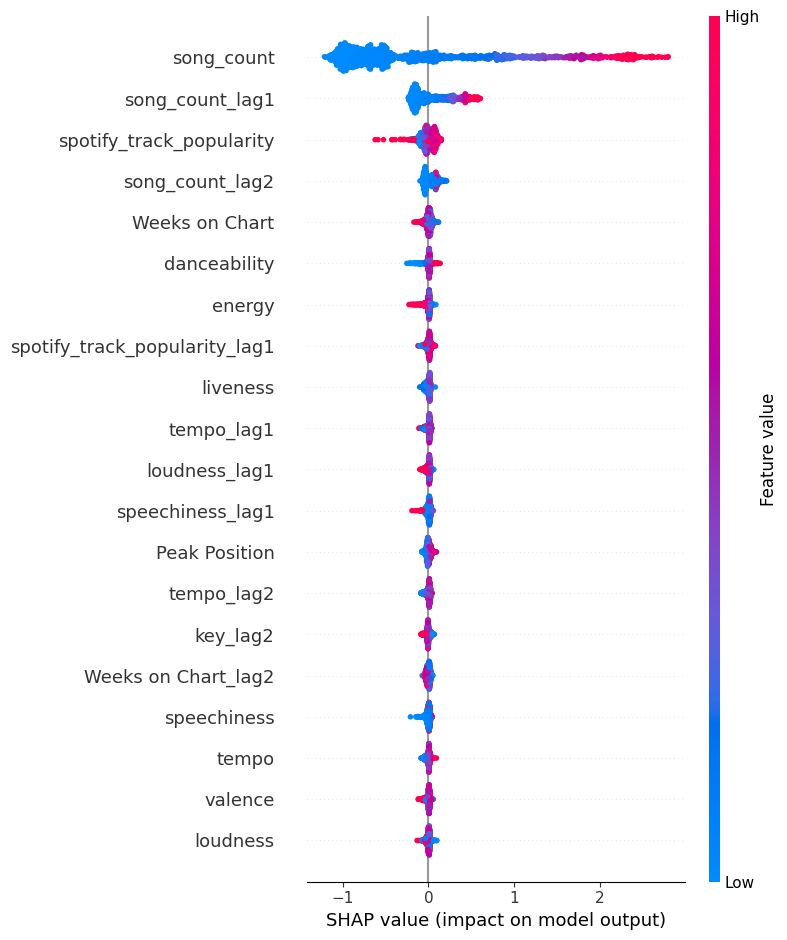

In [29]:
# SHAP values for feature importance, see how the model works
explainer = shap.Explainer(final_xgb_model)

# Compute SHAP values for test data
shap_values = explainer(X_test)

# Global feature importance (summary plot)
shap.summary_plot(shap_values, X_test)

Here we can see the features that were most influential for the model, with current song count sticking out once again. Other popularity metrics were also important features while genre characteristics like danceability, energy, etc. had slightly lesser yet still notable importance.

# Forecasting

Now that I've chosen and tuned my final model, it's time to revisit the out of sample data from earlier. As a reminder, this data was the most recent data or in other words the data we don't know future song counts for. Ideally this would represent data on genres from 2024/25 BUT the dataset I chose hadn't been updated to reflect that and only goes as far as 2021. So, with this out of sample data, I'll be forecasting song counts for genres in 2023.

In [ ]:
# prepare out of sample data for prediction
# restrict to genres with na song_count_2yr from 2021
forecast_df = oos_df[oos_df['Year'] == '2021']
print(forecast_df.info())

# drop nas (should only get rid of genres that didn't exist in past)
feature_cols = [col for col in forecast_df.columns if col not in ['spotify_genre', 'Year', 'song_count_2yr']]
forecast_df = forecast_df.dropna(subset=feature_cols)
print(forecast_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 132 entries, 130 to 12352
Data columns (total 63 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   spotify_genre                   132 non-null    object 
 1   Year                            132 non-null    object 
 2   spotify_track_duration_ms       132 non-null    float64
 3   danceability                    132 non-null    float64
 4   energy                          132 non-null    float64
 5   key                             132 non-null    float64
 6   loudness                        132 non-null    float64
 7   mode                            132 non-null    float64
 8   speechiness                     132 non-null    float64
 9   acousticness                    132 non-null    float64
 10  instrumentalness                132 non-null    float64
 11  liveness                        132 non-null    float64
 12  valence                         132 n

In [41]:
# make predictions using final xgb model
predictions = final_xgb_model.predict(forecast_df[feature_cols])

# add predictions back to forecast_df
forecast_df['song_count_2yr'] = predictions

# convert back to original scale
forecast_df['song_count_2yr'] = np.expm1(forecast_df['song_count_2yr'])

# print sorted results
forecast_df = forecast_df.sort_values(by='song_count_2yr', ascending=False)
print(forecast_df[['spotify_genre', 'Year', 'song_count_2yr']].head())

# save to csv
forecast_df[['spotify_genre', 'Year', 'song_count_2yr']].to_csv('data/forecast_df.csv', index=False)

             spotify_genre  Year  song_count_2yr
2911  contemporary country  2021      186.263245
8951                   pop  2021      141.809509
3042               country  2021      129.447052
3211          country road  2021      107.335060
9314         post-teen pop  2021      102.140656


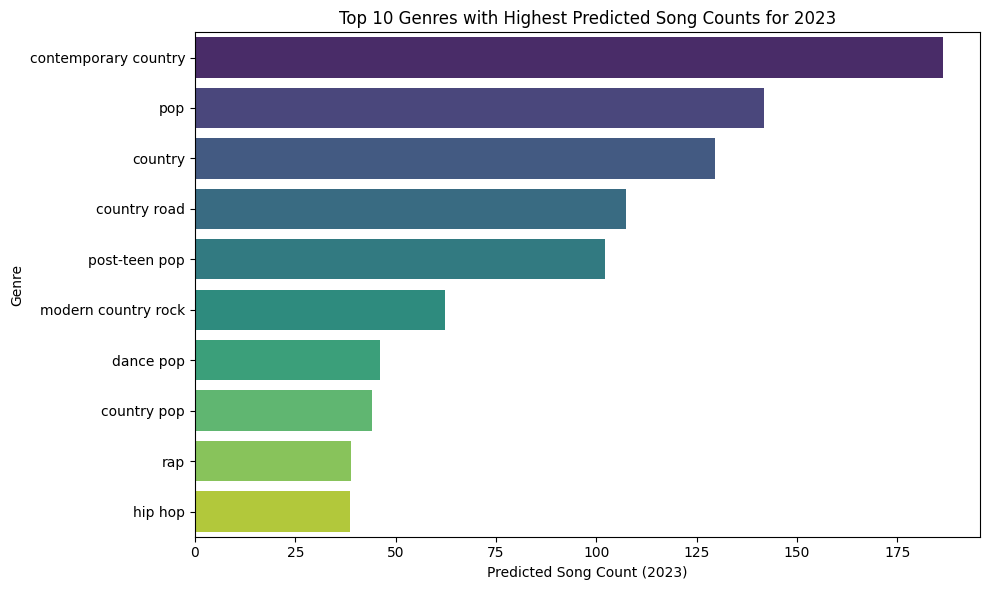

In [43]:
# plot top 10 genres
top_10_genres = forecast_df[['spotify_genre', 'Year', 'song_count_2yr']].head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_genres, x='song_count_2yr', y='spotify_genre', palette='viridis', hue='spotify_genre', legend=False)
plt.title('Top 10 Genres with Highest Predicted Song Counts for 2023')
plt.xlabel('Predicted Song Count (2023)')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

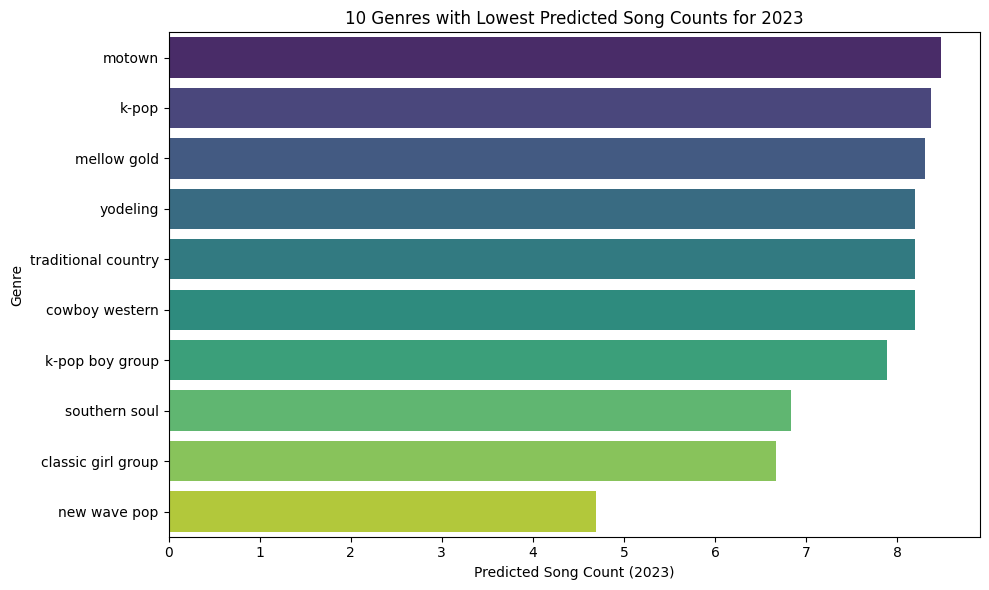

In [59]:
# plot bottom 10 genres
bottom_10_genres = forecast_df[['spotify_genre', 'Year', 'song_count_2yr']].tail(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=bottom_10_genres, x='song_count_2yr', y='spotify_genre', palette='viridis', hue='spotify_genre', legend=False)
plt.title('10 Genres with Lowest Predicted Song Counts for 2023')
plt.xlabel('Predicted Song Count (2023)')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

 99%|===================| 89/90 [00:15<00:00]        

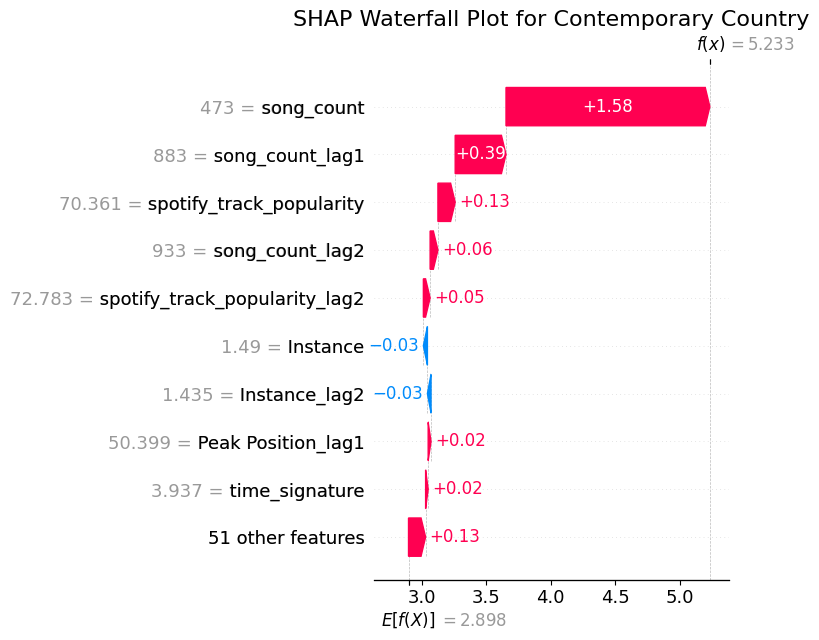

In [61]:
# waterfall plot for top genre
explainer = shap.Explainer(final_xgb_model, forecast_df[feature_cols])
shap_values = explainer(forecast_df[feature_cols])
shap.plots.waterfall(shap_values[0], max_display=10, show=False)

# add title
plt.title("SHAP Waterfall Plot for Contemporary Country", fontsize=16)
plt.tight_layout()
plt.show()

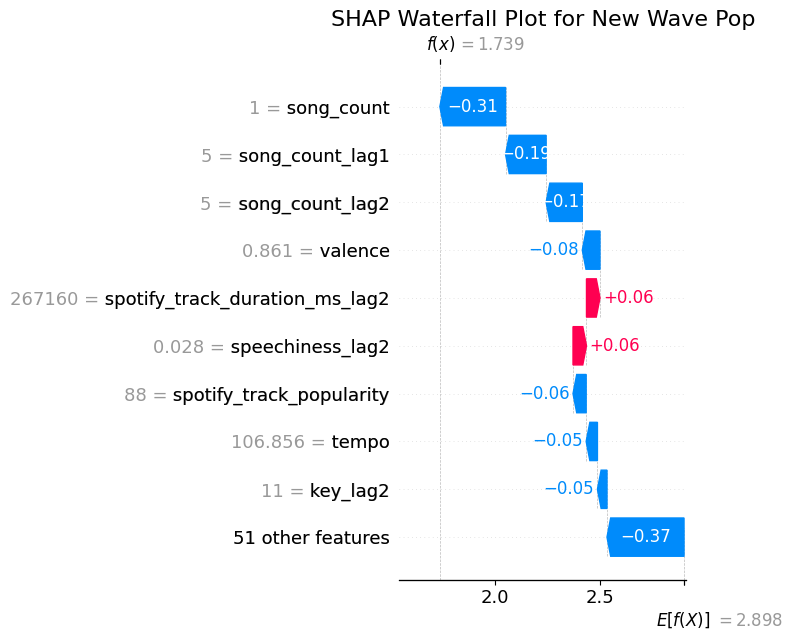

In [62]:
# waterfall plot for bottom genre
shap.plots.waterfall(shap_values[-1], max_display=10, show=False)

# add title
plt.title("SHAP Waterfall Plot for New Wave Pop", fontsize=16)
plt.tight_layout()
plt.show()

These forecasting results mostly matched my expectations. I was a little surprised that country music was expected to be so popular, but it's not a shocking result. One thing that I'd like to visit next would be to try and group similar genres before training. For example, contemporary country and country road could probably be lumped together into one big country category, and hip-hop and rap could be grouped together as well. I took a look at what drove the predictions for both contemporary country (top genre) and new wave pop (bottom genre) with some nice waterfall plots. These confirmed what I found earlier with song count and popularity really boosting the prediction for the top genre and dragging down the prediction for new wave pop.